# Подготовка набора данных

In [60]:
import os
import glob

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import lsb_replacement, aump, get_binary_plane

%reload_ext autoreload
%autoreload 2

## Исходные параметры для генерации набора данных

In [40]:
# Параметры для AUMP
PIXEL_SIZE = 128  # размер окна в пикселях
POLYNOMIAL_DEGREE = 7  # степень полинома для прогонки

# Параметры для НЗБ-встраивания
BINARY_NUM = 2  # 2-я битовая плоскость

In [41]:
# Зашумлённость
Q = [0.2, 0.4, 0.6, 0.8]

In [42]:
# Пути к директориям с исходными изображениями и набору данных
IMAGES_DIR = "./images"
DATASETS_DIR = "./datasets"

In [43]:
# Набор изображений
files = glob.glob(IMAGES_DIR + "/**/*.tif", recursive=True)
print("\n".join(files))

./images\Image00001.tif
./images\Image00002.tif
./images\Image00003.tif
./images\Image00004.tif
./images\Image00005.tif
./images\Image00006.tif
./images\Image00007.tif
./images\Image00008.tif
./images\Image00009.tif
./images\Image00010.tif
./images\Image00011.tif
./images\Image00012.tif
./images\Image00013.tif
./images\Image00014.tif
./images\Image00015.tif
./images\Image00016.tif
./images\Image00017.tif
./images\Image00018.tif
./images\Image00019.tif
./images\Image00020.tif
./images\Image00021.tif
./images\Image00022.tif
./images\Image00023.tif
./images\Image00024.tif
./images\Image00025.tif
./images\Image00026.tif
./images\Image00027.tif
./images\Image00028.tif
./images\Image00029.tif
./images\Image00030.tif
./images\Image00031.tif
./images\Image00032.tif
./images\Image00033.tif
./images\Image00034.tif
./images\Image00035.tif
./images\Image00036.tif
./images\Image00037.tif
./images\Image00038.tif
./images\Image00039.tif
./images\Image00040.tif
./images\Image00041.tif
./images\Image00

## Вспомогательные функции

In [44]:
def plot_grayscale_image(input_image: np.ndarray, title: str = None) -> None:
    """Отрисовка изображения в оттенках серого."""
    if title:
        plt.title(title)
    plt.imshow(input_image, cmap='gray')
    plt.axis("off")

## Пример работы

In [45]:
image_sample = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
image_sample.shape

(512, 512)

In [46]:
assert np.prod(image_sample.shape) % PIXEL_SIZE == 0, "Поменять значение PIXEL_SIZE"

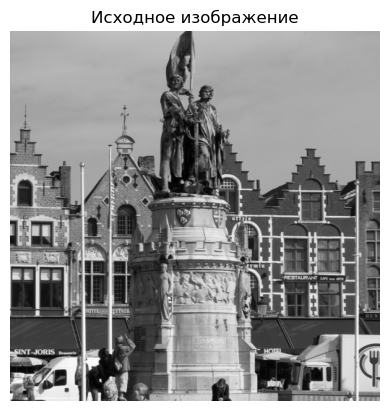

In [47]:
plot_grayscale_image(image_sample, "Исходное изображение")

In [48]:
%%time
lsb_image = lsb_replacement(image_sample, q=0.8, binary_num=BINARY_NUM)

CPU times: total: 1.27 s
Wall time: 1.27 s


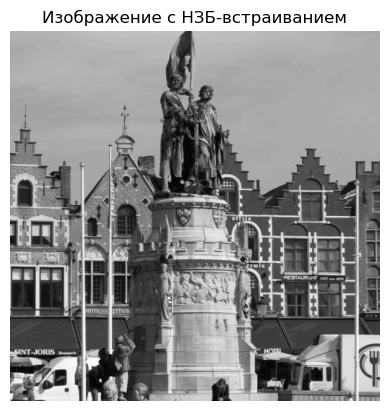

In [49]:
plot_grayscale_image(lsb_image, "Изображение с НЗБ-встраиванием")

In [50]:
binary_plane_image = get_binary_plane(image_sample, BINARY_NUM)
binary_plane_lsb_image = get_binary_plane(lsb_image, BINARY_NUM)
differences = binary_plane_image != binary_plane_lsb_image

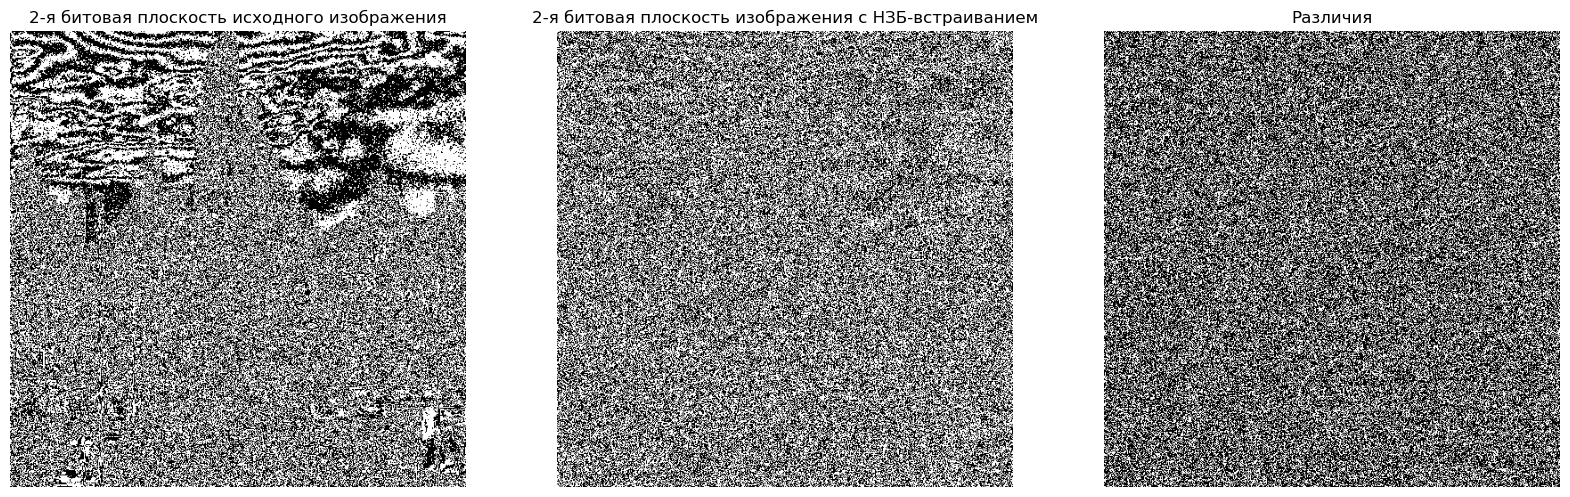

In [51]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plot_grayscale_image(binary_plane_image, f"{BINARY_NUM}-я битовая плоскость исходного изображения")

plt.subplot(1, 3, 2)
plot_grayscale_image(binary_plane_lsb_image, f"{BINARY_NUM}-я битовая плоскость изображения с НЗБ-встраиванием")

plt.subplot(1, 3, 3)
plot_grayscale_image(differences, "Различия")

In [61]:
# Вектор признаков при помощи AUMP
aump(lsb_image, m=PIXEL_SIZE, d=POLYNOMIAL_DEGREE)

c:\Users\Vladislav\Desktop\ML4S\ml-for-sec-lab2\utils\aump.py:73: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = lin.lstsq(H, y)[0]


0.9820743297874912

## Создание набора данных

In [62]:
files_with_lsb = files[:int(0.5 * len(files))]
files_without_lsb = files[int(0.5 * len(files)):]

In [63]:
datasets = {}

In [64]:
for q in Q:
    print(f"Зашумленность: {q}")
    datasets[q] = {}
    datasets[q]["with_lsb"] = []
    datasets[q]["without_lsb"] = []
    for file_ in tqdm(files):
        image_ = cv2.imread(file_, cv2.IMREAD_GRAYSCALE)
        if file_ in files_with_lsb:
            datasets[q]["with_lsb"].append(
                aump(
                    input_image=lsb_replacement(image_, q=q, binary_num=BINARY_NUM),
                    m=PIXEL_SIZE,
                    d=POLYNOMIAL_DEGREE,
                )
            )
        else:
            datasets[q]["without_lsb"].append(aump(image_, m=PIXEL_SIZE, d=POLYNOMIAL_DEGREE))

Зашумленность: 0.2


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Зашумленность: 0.4


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Зашумленность: 0.6


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Зашумленность: 0.8


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


In [65]:
aump_datasets_dir = DATASETS_DIR + "/aump"

In [66]:
for q_ in datasets.keys():
    dataset_name = aump_datasets_dir + f"/data_{str(q_).replace('.', '_')}.csv"
    with_lsb = datasets[q_]["with_lsb"]
    without_lsb = datasets[q_]["without_lsb"]
    features = with_lsb[0]

    columns = [f"feature_{i}" for i in range(len(features))]  if type(features) == list else ["feature_1"]
    with_lsb_df = pd.DataFrame(data=with_lsb, columns=columns)
    with_lsb_df["target"] = 1
    without_lsb_df = pd.DataFrame(data=without_lsb, columns=columns)
    without_lsb_df["target"] = 0

    result_df = pd.concat([with_lsb_df, without_lsb_df])

    result_df.to_csv(dataset_name, index=False)